efetua os imports das dependencias

In [0]:
!pip install unidecode

     |████████████████████████████████| 245kB 6.5MB/s 


In [0]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import unidecode as unidecode

In [0]:
  nltk.download('stopwords')
  nltk.download('rslp')
  nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

importa os dados do arquivo excel referente ao civil e adiciona a coluna CLASSE com o valor 0, representando o tipo de dado civil

In [0]:
uri_data_civel = 'https://github.com/julianopacheco/classificacao-textos-juridicos/blob/master/arquivos/xls/civel.xlsx?raw=true'
dados_civil = pd.read_excel(uri_data_civel)
dados_civil["CLASSE"] = 0
dados_civil.corr()

,PROCESSO,CLASSE
PROCESSO,1.0,NaN
CLASSE,NaN,NaN


importa os dados do arquivo excel referente ao crime e adiciona a coluna CLASSE com o valor 1, representando o tipo de dado crime

In [0]:
uri_data_crime = 'https://github.com/julianopacheco/classificacao-textos-juridicos/blob/master/arquivos/xls/crime.xlsx?raw=true'
dados_crime = pd.read_excel(uri_data_crime)
dados_crime["CLASSE"] = 1
dados_crime.corr()

,PROCESSO,CLASSE
PROCESSO,1.0,NaN
CLASSE,NaN,NaN


concatena as duas fontes de dados e gera uma nova contendo as duas

In [0]:
dados_civil_e_crime = pd.concat([dados_civil, dados_crime], axis=0)

In [0]:
dados_civil_e_crime.corr()

,PROCESSO,CLASSE
PROCESSO,1.000000,-0.228608
CLASSE,-0.228608,1.000000


como agora a fonte de dados contem as duas listas e necessário embaralhar elas para que o civil e crime nao venha na ordem que foram concatenados

isso e feito com o shuffle

In [0]:
dados_civil_e_crime = shuffle(dados_civil_e_crime)

In [0]:
dados_civil_e_crime[['EMENTA', 'CLASSE']].head()

,EMENTA,CLASSE
3298,AÇÃO COMINATÓRIA CUMULADA COM INDENIZAÇÃO. AÇÃ...,0
1408,APELAÇÃO CÍVEL. RECURSO ADESIVO. AGRAVO RETIDO...,0
4008,APELAÇÃO CRIMINAL. VIOLÊNCIA DOMÉSTICA. VIOLAÇ...,1
5993,APELAÇÃO CÍVEL. SERVIDOR PÚBLICO. MUNICÍPIO DE...,0
1607,APELAÇÃO CÍVEL. AÇÃO REVISIONAL. CONTRATOS DE ...,0


verifica a proporcionalidade de cada um dos tipos (civil = 0, crime = 1)

In [0]:
def removeCaput(text):
        
    words = text.split()
    
    sem_caput = []
    for w in words:
        if not w.isupper():
            sem_caput.append(w)
    
    result = ''
    for w in sem_caput:
        result = result + w + ' '
    return result

In [0]:
dados_civil_e_crime_sem_caput = [removeCaput(texto) for texto in dados_civil_e_crime["EMENTA"]]
dados_civil_e_crime["EMENTA_SEM_VERBATIZACAO"] = dados_civil_e_crime_sem_caput

In [0]:
dados_civil_e_crime[['EMENTA', 'EMENTA_SEM_VERBATIZACAO', 'CLASSE']].head()

,EMENTA,EMENTA_SEM_VERBATIZACAO,CLASSE
3298,AÇÃO COMINATÓRIA CUMULADA COM INDENIZAÇÃO. AÇÃ...,sabido que o direito de propriedade sobre as m...,0
1408,APELAÇÃO CÍVEL. RECURSO ADESIVO. AGRAVO RETIDO...,Agravo retido. Recurso conhecido e pedidos rej...,0
4008,APELAÇÃO CRIMINAL. VIOLÊNCIA DOMÉSTICA. VIOLAÇ...,Preliminar. Alegação de abandono do processo p...,1
5993,APELAÇÃO CÍVEL. SERVIDOR PÚBLICO. MUNICÍPIO DE...,1. direito líquido e certo é aquele que se mos...,0
1607,APELAÇÃO CÍVEL. AÇÃO REVISIONAL. CONTRATOS DE ...,Apelo não conhecido quanto aos pedidos de afas...,0


In [0]:
dados_civil_e_crime.CLASSE.value_counts()

1    6000
0    6000
Name: CLASSE, dtype: int64

extrai as ementas dos dados

In [0]:
ementas = dados_civil_e_crime["EMENTA_SEM_VERBATIZACAO"]


efetua o join das frases e junta todas as palavras de todas as frases n variavel all_words, escreve o total e monta a nuvem de palavras que será desenhada no próximo bloco de código

In [0]:
def gera_nuvem_palavras(text):
  all_words = ' '.join(text)
  word_cloud = WordCloud(width=1200, height=800).generate(all_words)
  print(f'total de palavras {len(all_words)}')
  return word_cloud

desenha a nuvem de palavras dando maior destaque para as palavras com maior frequencia

In [0]:
def desenha_palavras(word_cloud):
  plt.figure(figsize=(10,10))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

total de palavras 16294706


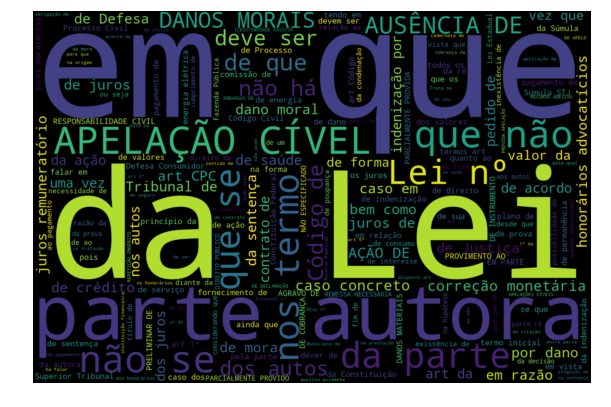

In [0]:
nuvem_palavras_civil = gera_nuvem_palavras(dados_civil.EMENTA)
desenha_palavras(nuvem_palavras_civil)

total de palavras 18277338


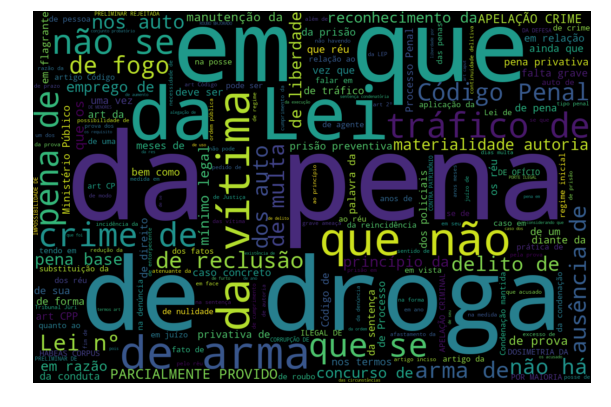

In [0]:
nuvem_palavras_crime = gera_nuvem_palavras(dados_crime.EMENTA)
desenha_palavras(nuvem_palavras_crime)

total de palavras 34572045


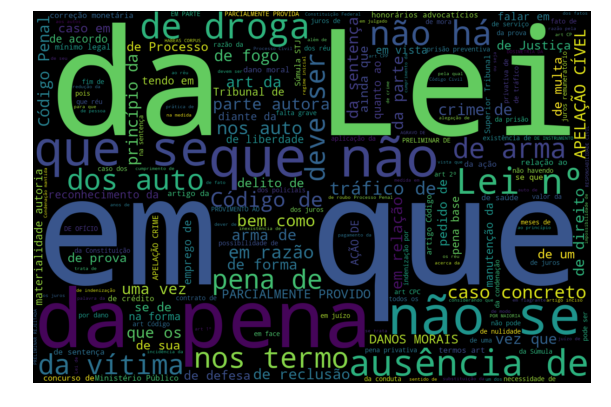

In [0]:
nuvem_palavras_civil_crime = gera_nuvem_palavras(dados_civil_e_crime.EMENTA)
desenha_palavras(nuvem_palavras_civil_crime)

total de palavras 29421348


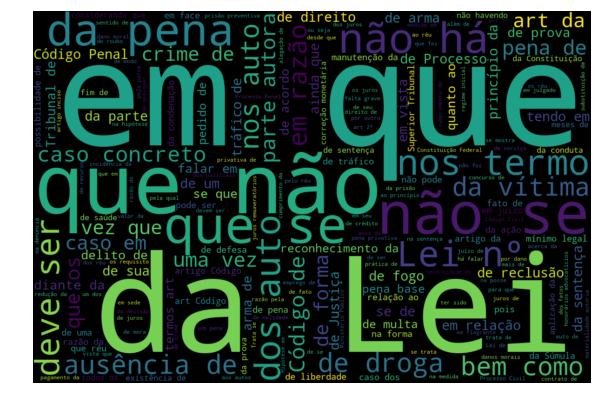

In [0]:
nuvem_palavras_civil_crime_sem_verbatizacao = gera_nuvem_palavras(dados_civil_e_crime.EMENTA_SEM_VERBATIZACAO)
desenha_palavras(nuvem_palavras_civil_crime_sem_verbatizacao)

metodo para tokenizar as palavras das frases e gerar a frequencia de cada palavra

In [0]:
import nltk as nltk
from nltk import tokenize
tokenizador = tokenize.WhitespaceTokenizer()
def gera_frequencia(tokenizador, textos):
  texto_tokenizado = tokenizador.tokenize(' '.join(textos))
  frequencia = nltk.FreqDist(texto_tokenizado)
  df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                "Frequencia": list(frequencia.values())})
  df_frequencia15 = df_frequencia.nlargest(columns = "Frequencia", n = 20)
  print(df_frequencia15)
  return df_frequencia15

metodo que escreve um grafico pareto das frequencias recebidas

In [0]:
def escreve_pareto(df_frequencia):
  import seaborn as sns
  plt.figure(figsize=(20,10))
  ax = sns.barplot(data = df_frequencia, x = "Palavra", y = "Frequencia")
  ax.set(ylabel = "Contagem")
  plt.show()

metodo que remove as stop words das frases

In [0]:
import string
stemmer = nltk.RSLPStemmer()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def remove_stopwords(tokenizador, textos):
  stop_words = nltk.corpus.stopwords.words("portuguese")
  stop_words.append('nao')
  print(stop_words)
  ementas_processadas = list()
  for ementa in textos:
    nova_ementa = list()
  #  print(ementa)
    palavras_ementa = tokenizador.tokenize(ementa)
    
    # remove punctuation from each word
  #  print(palavras_ementa)
    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in palavras_ementa]
     # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
  #  print(palavras_ementa)
    for palavra in words:
      if palavra.lower() not in stop_words:
        nova_ementa.append(wordnet_lemmatizer.lemmatize(palavra))
        #nova_ementa.append(stemmer.stem(palavra))
        #nova_ementa.append(palavra)
    ementas_processadas.append(' '.join(nova_ementa))
  return ementas_processadas

aqui utiliza os metodos anteriores para aplicar tratamento nas frases removendo as stop words e exibindo o retorno no formato de grafico posteriormente

In [0]:
ementas_trat_1 = [unidecode.unidecode(texto.lower()) for texto in dados_civil_e_crime["EMENTA_SEM_VERBATIZACAO"]]
#ementas_trat_1 = [unidecode.unidecode(texto.lower()) for texto in dados_civil_e_crime["EMENTA"]]
dados_civil_e_crime["EMENTA_SEM_CAPUT_TRAT_1"] = ementas_trat_1

In [0]:
punct_tokenize = tokenize.WordPunctTokenizer()
dados_civil_e_crime['EMENTAS_PROCESSADAS'] = remove_stopwords(tokenizador, dados_civil_e_crime.EMENTA_SEM_CAPUT_TRAT_1)



['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estivermos

       Palavra  Frequencia
11         art       21661
76         ser       16988
14        caso       15510
350       pena       15053
8          lei       13053
40         reu       12872
32        auto       11968
275      crime       10645
196      prova       10585
1408    artigo       10557
53       parte       10091
80    sentenca        9324
39        fato        8876
150      sendo        8320
284      penal        8053
547     codigo        8016
320         ha        7637
215     vitima        7479
134      forma        7084
201        poi        7030


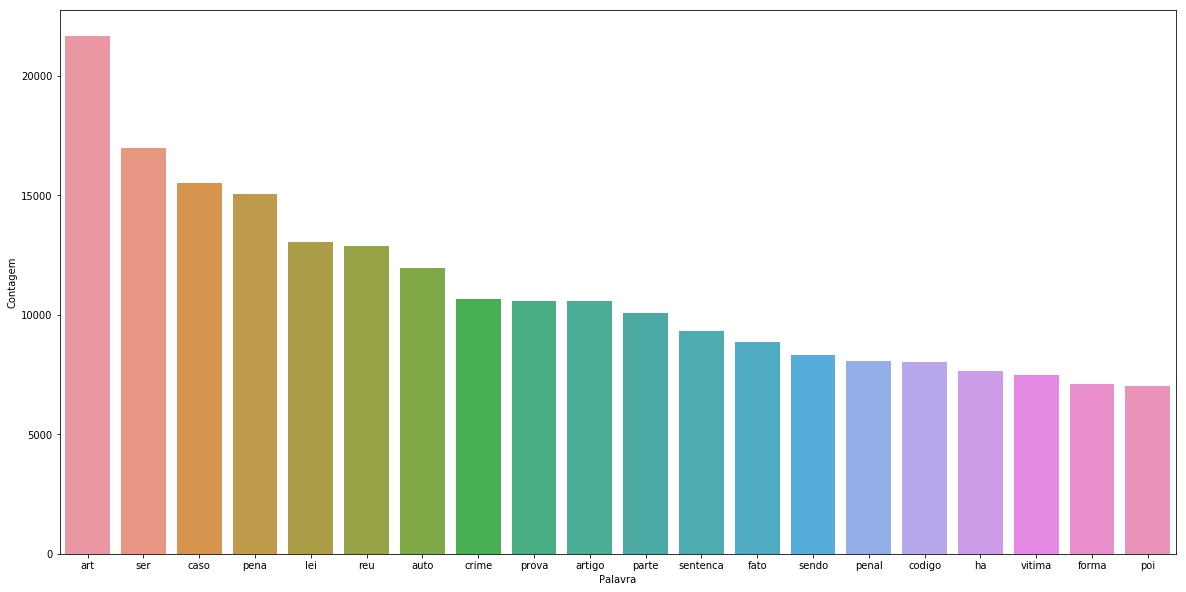

In [0]:
df_frequencia = gera_frequencia(tokenizador, dados_civil_e_crime.EMENTAS_PROCESSADAS)
escreve_pareto(df_frequencia)

total de palavras 22187444


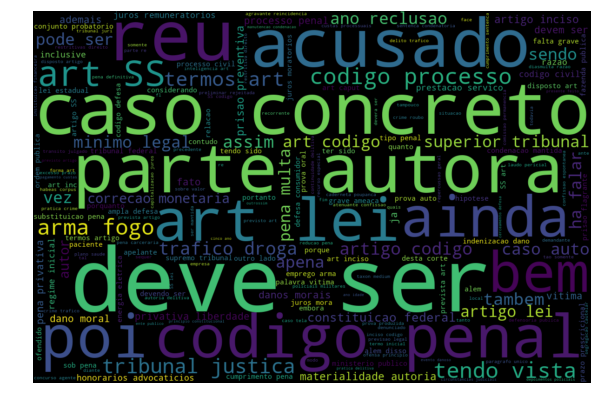

In [0]:
nuvem_palavras_processadas = gera_nuvem_palavras(dados_civil_e_crime.EMENTAS_PROCESSADAS)
desenha_palavras(nuvem_palavras_processadas)